## Solving y

In [1]:
from libnum import sqrtmod_prime_power, has_sqrtmod_prime_power

In [2]:
for i in range(0, 11):
    print(i, has_sqrtmod_prime_power(i, 11))

0 True
1 True
2 False
3 True
4 True
5 True
6 False
7 False
8 False
9 True
10 False


In [3]:
list(sqrtmod_prime_power(5, 11))

[4, 7]

In [4]:
assert (4 ** 2) % 11 == 5
assert (7 ** 2) % 11 == 5  # 7 == "-4" 

## Generate points

In [5]:
def gen_points(p):
    xs = []
    ys = []

    for x in range(p):
        y_sq = (x ** 3 + 3) % p
        if has_sqrtmod_prime_power(y_sq, p):
            roots = sqrtmod_prime_power(y_sq, p)
            for y in roots:
                xs.append(x)
                ys.append(y)

    return xs, ys

In [6]:
(xs, ys) = gen_points(11)
for point in zip(xs, ys):
    print(point)

(0, 5)
(0, 6)
(1, 9)
(1, 2)
(2, 0)
(4, 1)
(4, 10)
(7, 4)
(7, 7)
(8, 3)
(8, 8)


In [7]:
import matplotlib.pyplot as plt

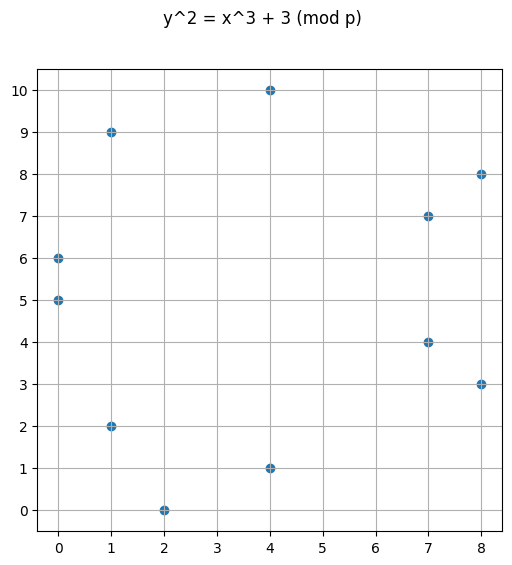

In [8]:
xs, ys = gen_points(11)
fig, (ax1) = plt.subplots(1, 1)
fig.suptitle('y^2 = x^3 + 3 (mod p)')
fig.set_size_inches(6, 6)
ax1.set_xticks(range(0, 11))
ax1.set_yticks(range(0, 11))
plt.grid()
plt.scatter(xs, ys)

## Point addition

In [9]:
def inv(x, p):
    return pow(x, -1, p)


def slope(x_p, y_p, x_q, y_q, p):
    if x_p == x_q and y_p == y_q:
        # P = Q
        return ((3 * x_p ** 2) % p * inv(2 * y_p, p)) % p
    else:
        # P != Q
        return ((y_q - y_p) * inv(x_q - x_p, p)) % p



In [10]:
assert inv(3, 11) == 4
assert inv(5, 11) == 9


In [11]:
def add(x_p, y_p, x_q, y_q, p):
    if x_p is y_p is None:
        # 0 + Q = Q
        return x_q, y_q

    if x_q is y_q is None:
        # P + 0 = P
        return x_p, y_p

    assert (x_q ** 3 + 3) % p == (y_q ** 2) % p, "q not on curve"
    assert (x_p ** 3 + 3) % p == (y_p ** 2) % p, "p not on curve"

    if x_p == x_q and y_p == (p - y_q) % p:
        # P + Q = 0
        return None, None

    m = slope(x_p, y_p, x_q, y_q, p)

    if x_p == x_q and y_p == y_q:
        x_r = (m ** 2 - 2 * x_p) % p
        y_r = (-m * x_r + m * x_p - y_p) % p
    else:
        x_r = (m ** 2 - x_p - x_q) % p
        y_r = (m * (x_p - x_r) - y_p) % p

    return x_r, y_r

In [12]:
# (0, 5) + (1, 9)
print(add(0, 5, 1, 9, 11))
# (0, 5) + (0, 6) = 0
print(add(0, 5, 0, 6, 11))
# (7, 7) + (7, 7)
print(add(7, 7, 4, 10, 11))


(4, 1)
(None, None)
(1, 9)


## Generating a subgroup from a generator point

In [13]:
def subgroup(x_g, y_g, p):
    xs = [None, x_g]
    ys = [None, y_g]

    for i in range(2, 12):
        prev_x, prev_y = xs[-1], ys[-1]
        (x, y) = add(prev_x, prev_y, x_g, y_g, p)
        xs.append(x)
        ys.append(y)

    return xs, ys


In [14]:
(xs, ys) = subgroup(7, 7, 11)
print(xs)
print(ys)

[None, 7, 0, 2, 0, 7, None, 7, 0, 2, 0, 7]
[None, 7, 6, 0, 5, 4, None, 7, 6, 0, 5, 4]


## Homomorphism to Integers mod p

In [15]:
def gen_phi(x_g, y_g, p):
    points = subgroup(x_g, y_g, p)
    pts_to_int = {}
    for (i, pt) in enumerate(zip(points[0], points[1])):
        pts_to_int[pt] = i
    return pts_to_int

In [16]:
phi = gen_phi(4, 10, 11)
print(phi)

{(None, None): 0, (4, 10): 1, (7, 7): 2, (1, 9): 3, (0, 6): 4, (8, 8): 5, (2, 0): 6, (8, 3): 7, (0, 5): 8, (1, 2): 9, (7, 4): 10, (4, 1): 11}


In [17]:
def check_phi(x_p, y_p, x_q, y_q, p, phi):
    group_order = len(phi)
    pt_sum = add(x_p, y_p, x_q, y_q, p)
    int_sum = (phi[(x_p, y_p)] + phi[x_q, y_q]) % group_order
    assert phi[pt_sum] == int_sum, f"phi(({x_p}, {y_p}) + ({x_q}, {y_q})) != phi(({x_p}, {y_p})) + phi(({x_q}, {y_q}))"

In [18]:
for x_p, y_p in phi:
    for x_q, y_q in phi:
        check_phi(x_p, y_p, x_q, y_q, 11, phi)

In [19]:
def multiply(x_p, y_p, p, n):
    # implements the "double and add" algorithm
    x, y = x_p, y_p
    x_res, y_res = None, None
    rem = n
    while rem > 0:
        if rem & 1 == 1:
            x_res, y_res = add(x_res, y_res, x, y, p)
        x, y = add(x, y, x, y, p)
        rem >>= 1
    return x_res, y_res

In [20]:
assert multiply(4, 10, 11, 0) == (None, None)
assert multiply(4, 10, 11, 1) == (4, 10)
assert multiply(4, 10, 11, 2) == (7, 7)


## Diffie-Hellman key exchange with my toy curve

In [23]:
# common reference point
x_g, y_g = 4, 10

# private key
a = 3
b = 4

# public key
A = multiply(x_g, y_g, 11, a)
B = multiply(x_g, y_g, 11, b)

# B -> (x, y)
Ba = multiply(B[0], B[1], 11, a)
Ab = multiply(A[0], A[1], 11, b)

assert Ab == Ba

# Simple argument of knowledge with my toy curve

I know x and y such that x + y = 15

In [22]:
# common reference point
x_g, y_g = 4, 10

# prover
x = 10
y = 5
X = multiply(x_g, y_g, 11, x)
Y = multiply(x_g, y_g, 11, y)

# verifier
z = 15
Z = multiply(x_g, y_g, 11, z)
assert add(X[0], X[1], Y[0], Y[1], 11) == Z